# <center style='color:lightcoral'> Classify `CIFAR100` images using pretrained `EfficientNetV2L` with PyTorch </center> 

## 1. Import the libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

## 2. Define the device

In [2]:
print('PyTorch version:', torch.__version__, '\n')
print('Torchvision version:', torchvision.__version__, '\n')

print('GPU name:', torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device, '\n')
print('Total number of GPUs:', torch.cuda.device_count())

PyTorch version: 2.0.1+cu117 

Torchvision version: 0.15.2+cu117 

GPU name: NVIDIA RTX A5000 

Device is: cuda 

Total number of GPUs: 1


## 3. Apply transformation

In [3]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

In [4]:
weights = models.EfficientNet_V2_L_Weights.DEFAULT
weights.transforms()

ImageClassification(
    crop_size=[480]
    resize_size=[480]
    mean=[0.5, 0.5, 0.5]
    std=[0.5, 0.5, 0.5]
    interpolation=InterpolationMode.BICUBIC
)

## 4. Load `CIFAR100` dataset

In [5]:
training_dataset = datasets.CIFAR100('./data_src', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100('./data_src', train=False, download=True, transform=transform)

100%|███████████████████████████████████████████████████| 169001437/169001437 [00:10<00:00, 16164846.42it/s]


Extracting ./data_src/cifar-100-python.tar.gz to ./data_src
Files already downloaded and verified


In [6]:
# check the length of training and test datasets

print('Length of the training dataset:', len(training_dataset))
print('Length of the test dataset:', len(test_dataset))

Length of the training dataset: 50000
Length of the test dataset: 10000


#### In total, there are `50000 images` in the `training set` and `10000 images` in the `test set`.

In [7]:
# check the shape of training and test datasets

print('Shape of the training dataset:', training_dataset.data.shape)
print('Shape of the test dataset:', test_dataset.data.shape)

Shape of the training dataset: (50000, 32, 32, 3)
Shape of the test dataset: (10000, 32, 32, 3)


Shape: (total images, height, width, channels)

#### The `spatial dimension` of the `color images` in the `CIFAR100 dataset` is `32x32` pixels.

In [8]:
classes = training_dataset.classes

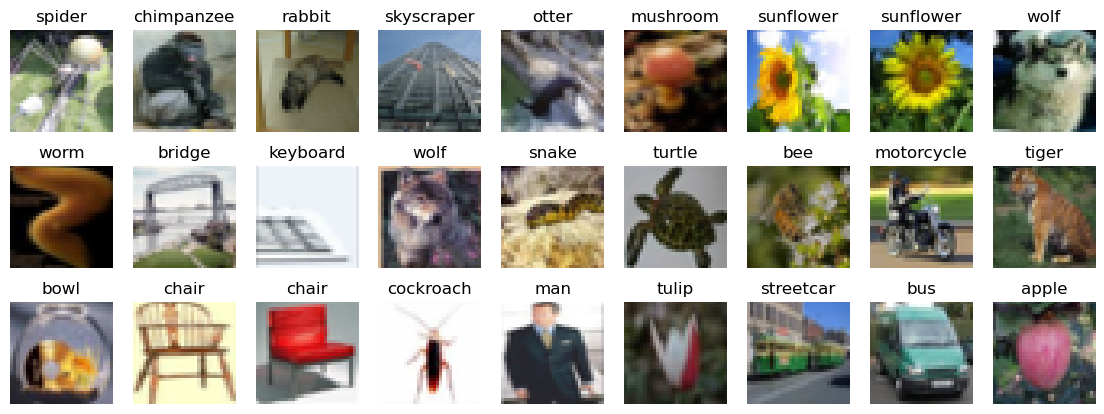

In [9]:
# show 27 randomly selected samples from the training dataset

fig, axis = plt.subplots(nrows=3, ncols=9, figsize=(14, 5))

for ax, _ in zip(axis.ravel(), range(27)):
    inx = np.random.randint(len(training_dataset))
    ax.imshow(training_dataset.data[inx])
    ax.set_title(classes[training_dataset.targets[inx]], fontsize=12)
    ax.axis(False);

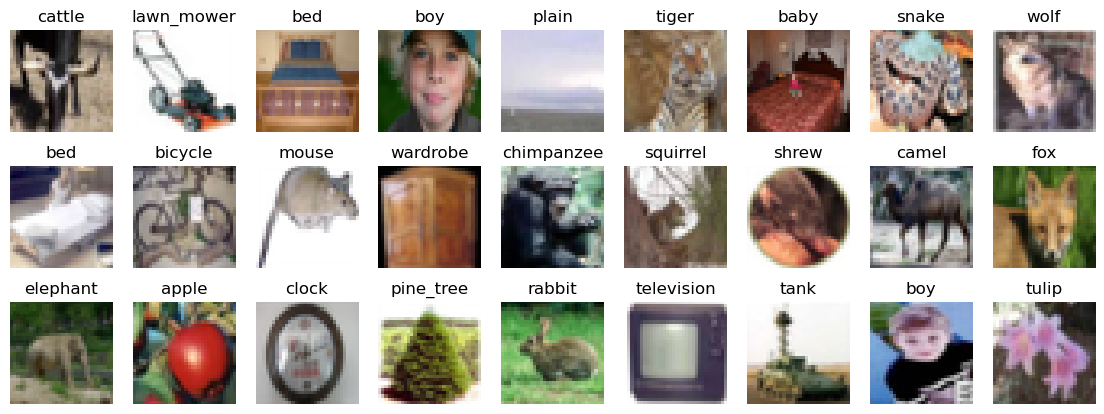

In [10]:
# show 27 randomly selected samples from the test dataset

fig, axis = plt.subplots(nrows=3, ncols=9, figsize=(14, 5))

for ax, _ in zip(axis.ravel(), range(27)):
    inx = np.random.randint(len(test_dataset))
    ax.imshow(test_dataset.data[inx])
    ax.set_title(classes[test_dataset.targets[inx]], fontsize=12)
    ax.axis(False);

## 5. Define dataloaders

In [11]:
training_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

In [12]:
# check the length of training and test dataloaders

print('Length of the training dataloader:', len(training_dataloader))
print('Length of the test dataloader:', len(test_dataloader))

Length of the training dataloader: 1562
Length of the test dataloader: 312


Since, neither 50000 nor 10000 is divisible by 32; the last batch will not have 32 images in it and hence I dropped it. 1562 and 312 are showing the number of batches in training and test dataloaders, respectively.

#### Dataloader converts a dataset into an iterable.

## 6. The pretrained network (`EfficientNetV2L`) architecture

In [13]:
EfficientNetV2L = models.efficientnet_v2_l(weights=models.EfficientNet_V2_L_Weights.IMAGENET1K_V1)

## 7. Visualize the pretrained model (`VGG16`) architecture

In [14]:
model = EfficientNetV2L.to(device)
summary(model, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 1000]                --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 32, 112, 112]        --
│    │    └─FusedMBConv: 3-4                            [32, 32, 112, 112]        9,280
│    │    └─FusedMBConv: 3-5                            [32, 32, 112, 112]        9,280
│    │    └─FusedMBConv: 3-6                            [32, 32, 112, 112]        9,280
│    │    └─FusedMBConv: 3-7                      

In [15]:
model.parameters

<bound method Module.parameters of EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine

## 8. Modified pretrained network (`modified_EfficientNetV2L`) architecture for `CIFAR100` images

In [16]:
modified_EfficientNetV2L = models.efficientnet_v2_l(weights=models.EfficientNet_V2_L_Weights.IMAGENET1K_V1)
for param in modified_EfficientNetV2L.parameters():
    param.requires_grad = False
    
modified_EfficientNetV2L.classifier = nn.Sequential()
modified_EfficientNetV2L.classifier.add_module('dropout1', nn.Dropout(p=0.4, inplace=True))
modified_EfficientNetV2L.classifier.add_module('linear1', nn.Linear(in_features=1280, out_features=1000))
modified_EfficientNetV2L.classifier.add_module('dropout2', nn.Dropout(p=0.4, inplace=True))
modified_EfficientNetV2L.classifier.add_module('linear2', nn.Linear(in_features=1000, out_features=100))

## 9. Visualize the modified pretrained model (`modified_EfficientNetV2L`) architecture

In [17]:
modified_model = modified_EfficientNetV2L.to(device)
summary(modified_model, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 100]                 --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        (864)
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        (64)
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 32, 112, 112]        --
│    │    └─FusedMBConv: 3-4                            [32, 32, 112, 112]        (9,280)
│    │    └─FusedMBConv: 3-5                            [32, 32, 112, 112]        (9,280)
│    │    └─FusedMBConv: 3-6                            [32, 32, 112, 112]        (9,280)
│    │    └─FusedMBConv: 3-7            

In [18]:
modified_model.parameters

<bound method Module.parameters of EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine

## 10. Define the training batch

In [19]:
def training_batch(data, labels, model, criterion, optimizer):
    model.train()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

## 11. Define the test batch

In [20]:
with torch.inference_mode():
    def test_batch(data, labels, model, criterion):
        model.eval()
        data = data.to(device)
        labels = labels.to(device)
        output = model(data)
        loss = criterion(output, labels)
        return loss

## 12. Define the accuracy function

In [21]:
with torch.inference_mode():
    def accuracy(data, labels, model):
        model.eval()
        data = data.to(device)
        labels = labels.to(device)
        output = model(data)
        _, pred_labels = output.max(-1)
        correct = (pred_labels == labels)
        return correct.cpu().detach().numpy().tolist()

## 13. Set up model_to_train (`modified_EfficientNetV2L`), criterion (`loss function`) and optimizer

In [22]:
model_to_train = modified_EfficientNetV2L.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_to_train.parameters(), lr=0.01)

## 14. Train the model

In [23]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

n_epochs = 15

training_loss, test_loss = [], []
training_accuracy, test_accuracy = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []
    training_accuracies, test_accuracies = [], []
    
    for data, labels in training_dataloader:
        trng_batch_loss = training_batch(data, labels, model_to_train, criterion, optimizer)
        training_losses.append(trng_batch_loss.item())
        trng_batch_correct = accuracy(data, labels, model_to_train)
        training_accuracies.extend(trng_batch_correct)
    training_per_epoch_loss = np.array(training_losses).mean()
    training_per_epoch_accuracy = np.mean(training_accuracies)
    
    for data, labels in test_dataloader:
        tst_batch_loss = test_batch(data, labels, model_to_train, criterion)
        test_losses.append(tst_batch_loss.item())
        tst_batch_correct = accuracy(data, labels, model_to_train)
        test_accuracies.extend(tst_batch_correct)
    test_per_epoch_loss = np.array(test_losses).mean()
    test_per_epoch_accuracy = np.mean(test_accuracies)
    
    training_loss.append(training_per_epoch_loss)
    training_accuracy.append(training_per_epoch_accuracy)
    test_loss.append(test_per_epoch_loss)
    test_accuracy.append(test_per_epoch_accuracy)
    
    print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} | ', end='')
    print(f'Training accuracy: {training_per_epoch_accuracy:.4f} | Test loss: {test_per_epoch_loss:.4f} | ', end='')
    print(f'Test accuracy: {test_per_epoch_accuracy:.4f}')

Epoch: 1/15	| Training loss: 3.3138 | Training accuracy: 0.4802 | Test loss: 2.1028 | Test accuracy: 0.5775
Epoch: 2/15	| Training loss: 2.0847 | Training accuracy: 0.6569 | Test loss: 1.5523 | Test accuracy: 0.6307
Epoch: 3/15	| Training loss: 1.8388 | Training accuracy: 0.6971 | Test loss: 1.3648 | Test accuracy: 0.6528
Epoch: 4/15	| Training loss: 1.7430 | Training accuracy: 0.7180 | Test loss: 1.2893 | Test accuracy: 0.6673
Epoch: 5/15	| Training loss: 1.6893 | Training accuracy: 0.7329 | Test loss: 1.2446 | Test accuracy: 0.6739
Epoch: 6/15	| Training loss: 1.6545 | Training accuracy: 0.7416 | Test loss: 1.1973 | Test accuracy: 0.6818
Epoch: 7/15	| Training loss: 1.6302 | Training accuracy: 0.7494 | Test loss: 1.1815 | Test accuracy: 0.6816
Epoch: 8/15	| Training loss: 1.6112 | Training accuracy: 0.7549 | Test loss: 1.1529 | Test accuracy: 0.6910
Epoch: 9/15	| Training loss: 1.5913 | Training accuracy: 0.7609 | Test loss: 1.1385 | Test accuracy: 0.6950
Epoch: 10/15	| Training loss

## 15. Plot model loss and accuracy

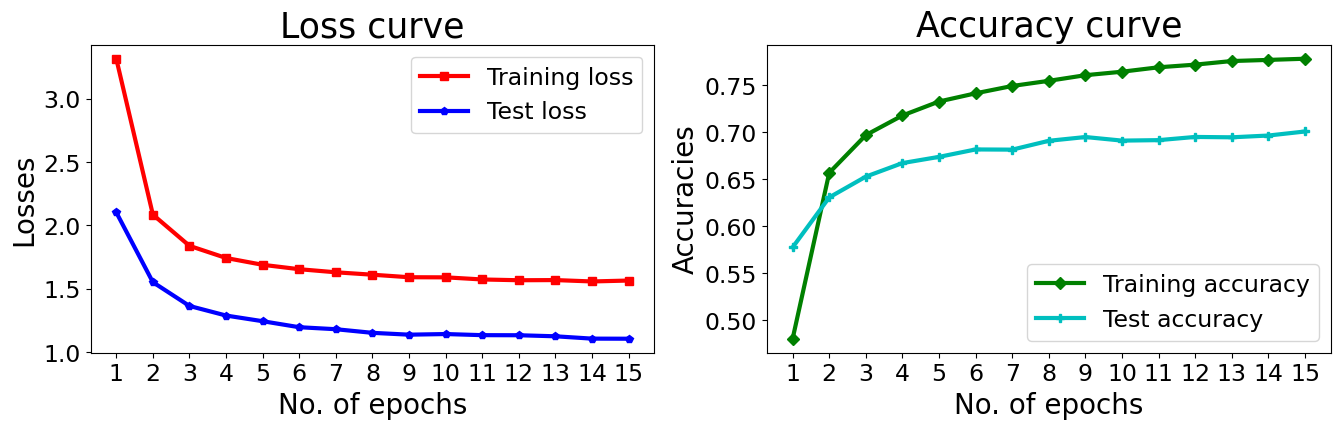

In [24]:
N = np.arange(n_epochs) + 1

fig = plt.figure(figsize=(16, 4))

fig.add_subplot(1, 2, 1)
plt.plot(N, training_loss, 'r-s', linewidth=3, label='Training loss')
plt.plot(N, test_loss, 'b-p', linewidth=3, label='Test loss')
plt.title('Loss curve', fontsize=25)
plt.xlabel('No. of epochs', fontsize=20)
plt.ylabel('Losses', fontsize=20)
plt.xticks(N, fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=17)

fig.add_subplot(1, 2, 2)
plt.plot(N, training_accuracy, 'g-D', linewidth=3, label='Training accuracy')
plt.plot(N, test_accuracy, 'c-P', linewidth=3, label='Test accuracy')
plt.title('Accuracy curve', fontsize=25)
plt.xlabel('No. of epochs', fontsize=20)
plt.ylabel('Accuracies', fontsize=20)
plt.xticks(N, fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=17);

## 16. Model prediction

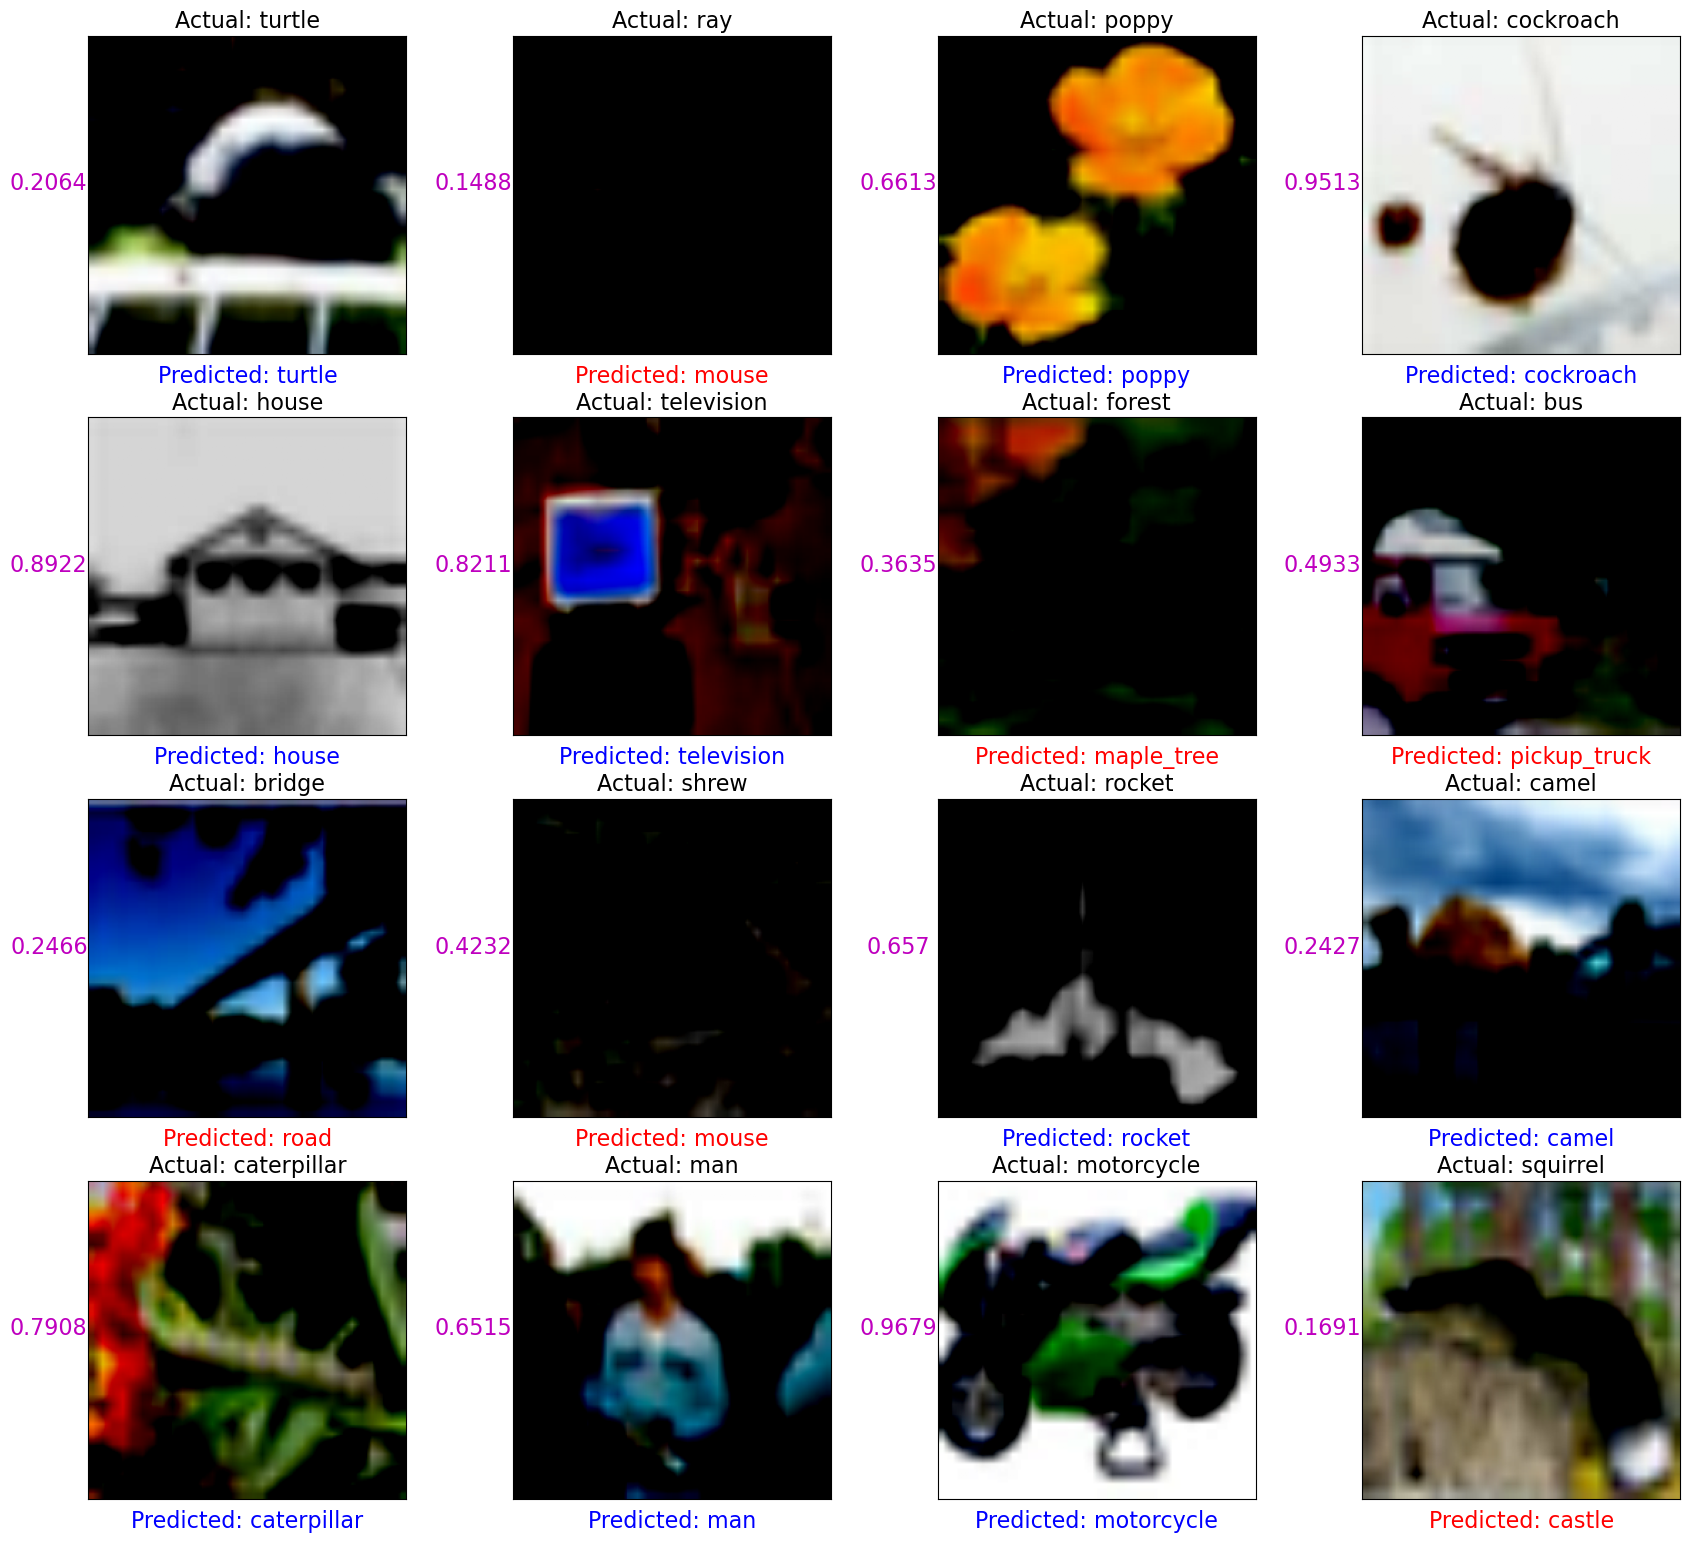

In [25]:
SAMPLES, PREDS, LABELS = [], [], []

for a in range(16):
    idx = np.random.randint(len(test_dataset))
    SAMPLES.append(test_dataset[idx])
    output = F.softmax(model_to_train.cpu()(SAMPLES[a][0].unsqueeze(0)), dim=-1)
    pred_values, pred_labels = output.max(-1)
    PREDS.append(round(float(pred_values), 4))
    LABELS.append(int(pred_labels))

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(21, 19))
i = 0
for R in range(4):
    for C in range(4):
        ax[R, C].imshow(torch.clamp(SAMPLES[i][0], min=0, max=1).permute(1, 2, 0))
        ax[R, C].set_title('Actual: ' + classes[SAMPLES[i][1]], fontsize=16).set_color('k') # actual labels
        if SAMPLES[i][1] == LABELS[i]:
            ax[R, C].set_xlabel('Predicted: ' + classes[LABELS[i]], fontsize=16).set_color('b') # correctly predicted labels
        else:
            ax[R, C].set_xlabel('Predicted: ' + classes[LABELS[i]], fontsize=16).set_color('r') # wrongly predicted labels
        ax[R, C].set_ylabel(PREDS[i], fontsize=16, rotation=0, labelpad=25).set_color('m') # probability of predicted class
        ax[R, C].set_xticks([])
        ax[R, C].set_yticks([])
        i += 1